recommender.py - класс с самим рекомендатором, там fit, predict и всякие set'ы<br>
utils.py - метрики и вспомогательные функции загрузки данных<br>
model.py - сама нейронка<br>
loader.py - загрузчик датасета для нейронки<br>
Иходные данные https://www.kaggle.com/c/instacart-market-basket-analysis/data<br>
analysis - всякие графики и статистика<br>
Там 206 000 покупателей, чтобы было быстрее берём 10 000 случайных

In [1]:
# Чтобы jupyter видел .py файлы в текущей папке
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parents[0] / "py"))

In [2]:
import pickle
import pandas as pd
import numpy as np
from random import randrange
from recommender import Recommender
from utils import mapk, hitk, split, load_data

In [4]:
# Возьмём 10 000 случайных пользователей.

orders = pd.read_csv('orders.csv')[['user_id', 'order_id', 'order_number']]
users_subsample = random.sample(orders['user_id'].unique().tolist(), 10000)
with open('saves/users_subsample.pickle', 'wb') as out:
    pickle.dump(users_subsample, out)

orders = orders[orders['user_id'].isin(users_subsample)]
split(orders)

train_df, validation_df, test_df, user_enum, product_enum = load_data()

In [47]:
from tqdm.notebook import tqdm

mapk_val, mapk_train, hitk_val, hitk_train = [], [], [], []

# Для обучения для каждого купленного пользователем продукта выбираем несколько продуктов, которые он не покупал
# Оптимально на один купленный 3 негативных
for neg in tqdm([1,2,3,4,5,6]):
    # Если обучаяем с нуля
    recommender = Recommender(train_df, validation_df, test_df, neg_num=neg)
    recommender.train_data.to_csv('saves/train_data_for_model-{}_neg.csv'.format(neg), index=False)
    recommender.val_data.to_csv('saves/val_data_for_model.csv'.format(neg), index=False)
    recommender.test_data.to_csv('saves/test_data_for_model.csv'.format(neg).csv', index=False)
    recommender.set_components_number(5) # число компонент в эмбэдинге
    recommender.fit('saves/model-5-{}neg.pickle'.format(neg), epochs=5)

    # Если уже обучили и сохранили данные и модели, то просто загружаем их
#     recommender = Recommender(neg_num=neg)
#     recommender.set_components_number(5) # число компонент в эмбэдинге
#     recommender.set_data_for_model('saves/train_data_for_model-{}_neg.csv'.format(neg), 'saves/val_data_for_model.csv', 'saves/test_data_for_model.csv')
#     recommender.set_model('saves/model-5-{}neg.pickle'.format(neg))
    
    val_dict = recommender.val_data.groupby('user_id')['product_id'].apply(list).to_dict()
    actual_val_dict = recommender.val_data[recommender.val_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()
    train_dict = recommender.train_data.groupby('user_id')['product_id'].apply(list).to_dict()
    actual_train_dict = recommender.train_data[recommender.train_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()

    # В валидационной выборке для каждого покупателя на один купленный продукт есть 10 некупленных
    # Предсказываем для продуктов вероятность, что пользователь их купит, сортируем
    # map@k учитывает место, на котором находится продукт в отсортированных предсказаниях, это метрика ранжирования
    # p@k не учитывает место в отсортированном списке где стоят нужные продукты, проверяем только их наличие
    preds = []
    actuals = []
    for user, items in val_dict.items():
        res = recommender.predict_for_user(user, items).tolist()
        preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
        actuals += [actual_val_dict[user]]
    mapk_val += [mapk(actuals, preds)]
    hitk_val += [hitk(actuals, preds)]
    
    preds = []
    actuals = []
    for user, items in train_dict.items():
        res = recommender.predict_for_user(user, items).tolist()
        preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
        actuals += [actual_train_dict[user]]
    mapk_train += [mapk(actuals, preds)]
    hitk_train += [hitk(actuals, preds)]

  0%|          | 0/6 [00:00<?, ?it/s]

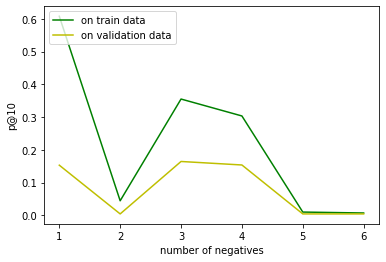

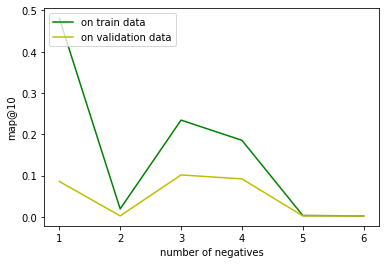

In [48]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([1, 2, 3, 4, 5, 6], hitk_train, label='on train data', c='g'),
plt.plot([1, 2, 3, 4, 5, 6], hitk_val, label='on validation data', c='y')
plt.xlabel('number of negatives')
plt.ylabel('p@10')
plt.legend(loc='upper left')
plt.show()
plt.figure(2)
plt.plot([1, 2, 3, 4, 5, 6], mapk_train, label='on train data', c='g'),
plt.plot([1, 2, 3, 4, 5, 6], mapk_val, label='on validation data', c='y')
plt.xlabel('number of negatives')
plt.ylabel('map@10')
plt.legend(loc='upper left')
plt.show()

In [50]:
from tqdm.notebook import tqdm

optimal_neg_num = 3
recommender = Recommender(neg_num=optimal_neg_num)
recommender.set_data_for_model('saves/train_data_for_model-{}_neg.csv'.format(optimal_neg_num), 'saves/val_data_for_model.csv', 'saves/test_data_for_model.csv')

val_dict = recommender.val_data.groupby('user_id')['product_id'].apply(list).to_dict()
actual_val_dict = recommender.val_data[recommender.val_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()
train_dict = recommender.train_data.groupby('user_id')['product_id'].apply(list).to_dict()
actual_train_dict = recommender.train_data[recommender.train_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()

mapk_val, mapk_train, hitk_val, hitk_train = [], [], [], []

for comp in tqdm([3, 4, 5, 6, 7, 8]):
    recommender.set_components_number(comp)
    recommender.fit('saves/model-{}-{}neg.pickle'.format(comp, optimal_neg_neg), epochs=5)
#     recommender.set_model('saves/model-{}-{}neg.pickle'.format(comp, optimal_neg_num))
    
    preds = []
    actuals = []
    for user, items in val_dict.items():
        res = recommender.predict_for_user(user, items).tolist()
        preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
        actuals += [actual_val_dict[user]]
    mapk_val += [mapk(actuals, preds)]
    hitk_val += [hitk(actuals, preds)]
    
    preds = []
    actuals = []
    for user, items in train_dict.items():
        res = recommender.predict_for_user(user, items).tolist()
        preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
        actuals += [actual_train_dict[user]]
    mapk_train += [mapk(actuals, preds)]
    hitk_train += [hitk(actuals, preds)]

  0%|          | 0/6 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 30.0 K
1 | item_embedding | Embedding | 106 K 
2 | fc1            | Linear    | 210   
3 | fc2            | Linear    | 465   
4 | fc3            | Linear    | 48    
5 | output         | Linear    | 4     
---------------------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.551     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 40.0 K
1 | item_embedding | Embedding | 142 K 
2 | fc1            | Linear    | 360   
3 | fc2            | Linear    | 820   
4 | fc3            | Linear    | 84    
5 | output         | Linear    | 5     
---------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 50.0 K
1 | item_embedding | Embedding | 178 K 
2 | fc1            | Linear    | 550   
3 | fc2            | Linear    | 1.3 K 
4 | fc3            | Linear    | 130   
5 | output         | Linear    | 6     
---------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.921     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 60.0 K
1 | item_embedding | Embedding | 213 K 
2 | fc1            | Linear    | 780   
3 | fc2            | Linear    | 1.8 K 
4 | fc3            | Linear    | 186   
5 | output         | Linear    | 7     
---------------------------------------------
276 K     Trainable params
0         Non-trainable params
276 K     Total params
1.107     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 70.0 K
1 | item_embedding | Embedding | 249 K 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.5 K 
4 | fc3            | Linear    | 252   
5 | output         | Linear    | 8     
---------------------------------------------
323 K     Trainable params
0         Non-trainable params
323 K     Total params
1.293     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 80.0 K
1 | item_embedding | Embedding | 285 K 
2 | fc1            | Linear    | 1.4 K 
3 | fc2            | Linear    | 3.2 K 
4 | fc3            | Linear    | 328   
5 | output         | Linear    | 9     
---------------------------------------------
370 K     Trainable params
0         Non-trainable params
370 K     Total params
1.480     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

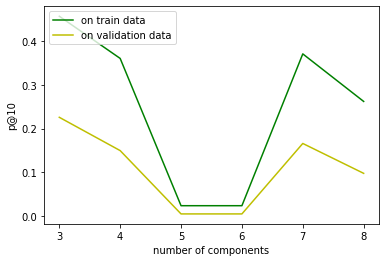

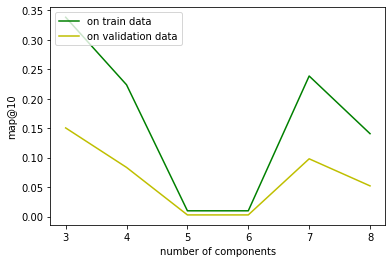

In [51]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([3, 4, 5, 6, 7, 8], hitk_train, label='on train data', c='g'),
plt.plot([3, 4, 5, 6, 7, 8], hitk_val, label='on validation data', c='y')
plt.xlabel('number of components')
plt.ylabel('p@10')
plt.legend(loc='upper left')
plt.show()
plt.figure(2)
plt.plot([3, 4, 5, 6, 7, 8], mapk_train, label='on train data', c='g'),
plt.plot([3, 4, 5, 6, 7, 8], mapk_val, label='on validation data', c='y')
plt.xlabel('number of components')
plt.ylabel('map@10')
plt.legend(loc='upper left')
plt.show()

In [58]:
# orders = pd.read_csv('orders.csv')[['user_id', 'order_id', 'order_number']]
# users_subsample = random.sample(orders['user_id'].unique().tolist(), 10000)
# orders = orders[orders['user_id'].isin(users_subsample)]
# split(orders)

train_df, validation_df, test_df, user_enum, product_enum = load_data()
recommender = Recommender(train_df, validation_df, test_df, neg_num=3)
recommender.set_components_number(3)
recommender.fit('saves/model.pickle',epochs=10)

test_dict = recommender.test_data.groupby('user_id')['product_id'].apply(list).to_dict()
actual_test_dict = recommender.test_data[recommender.test_data['bought'] != 0].groupby('user_id')['product_id'].apply(list).to_dict()

preds = []
actuals = []
for user, items in test_dict.items():
    res = recommender.predict_for_user(user, items).tolist()
    preds += [[x for _, x in sorted(zip(res, items), reverse=True)]]
    actuals += [actual_test_dict[user]]
mapk_test = mapk(actuals, preds)
hitk_test = hitk(actuals, preds)

print('3 negative examples, 3 components in embedding, 10 epochs:')
print('mAP@10 {}'.format(mapk_test))
print('mP@10 {}'.format(hitk_test))

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 30.0 K
1 | item_embedding | Embedding | 106 K 
2 | fc1            | Linear    | 210   
3 | fc2            | Linear    | 465   
4 | fc3            | Linear    | 48    
5 | output         | Linear    | 4     
---------------------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.551     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

3 negative examples, 3 components in embedding, 10 epochs:
mAP@10 0.3606912795422603
mP@10 0.4235876589535126


In [96]:
user_id = 123
user_data = recommender.test_data[recommender.test_data['user_id'] == user_id]
actual = user_data[user_data['bought'] != 0]['product_id'].to_list()
to_predict = user_data['product_id'].to_list()
res = recommender.predict_for_user(user_id, to_predict).tolist()
predicted = [x for _, x in sorted(zip(res, to_predict), reverse=True)][:20]
inv_product_enum = {v: k for k, v in product_enum.items()}
predicted = [inv_product_enum[i] for i in predicted]
actual = [inv_product_enum[i] for i in actual]

hits = np.intersect1d(predicted, actual)
products = pd.read_csv('products.csv')
predicted = list(products[products['product_id'].isin(predicted)]['product_name'])
actual = list(products[products['product_id'].isin(actual)]['product_name'])
hits = list(products[products['product_id'].isin(hits)]['product_name'])
print('Recommendations:')
print(*predicted, sep='\n')
print('\nActual:')
print(*actual, sep='\n')
print('\nHits:')
print(*hits, sep='\n')

Recommendations:
Mango Probiotic Juice Drink
100% Recycled Paper Towels
Apple Honeycrisp Organic
Gripe Water
Bag of Organic Bananas
Organic Yerba Mate Traditional
Kisses Milk Chocolate
Ezekiel 4:9 Bread Organic Sprouted Whole Grain
Ginger Peach Decaf Longevity Tea Bags
Frozen Greek Yogurt Bars Blueberry
Organic Large Brown Grade AA Cage Free Eggs
Original No Pulp Pure 100% Florida Orange Juice
Organic Unsweetened Almond Milk
Coffee Toffee Bar Crunch Ice Cream
Organic Grape Tomatoes
Dog Treats, Premium, Chicken, Small Size
Cheesecake, Chocolate Truffle
Raw Protein Chocolate Cacao
Soft Baked Minis Snack Packs Double Chocolate Brownie - 6 PK
Organic Avocado

Actual:
Key Lime Moisture Shave
Low Fat Kefir Cultured Milk Smoothie Lowfat Probiotic Blueberry
Sustainably Soft Bath Tissue
Organic Turmeric Tonic Juice
Mango Probiotic Juice Drink
Rhodiola Rosea, Standardized, Premium Extract, Vegetarian Vcaps
Organic Turkey Bacon
Hand Soap Lavender & Coconut
Dishwasher Gel Free & Clear
100% Recycle